<h1>Salary Predictions Based on Job Descriptions</h1>

'''This notebook pulls in salary data, builds and tests several predictive models,
   and then makes salary predictions on test data using the best model.'''

__author__ = "Jennifer Ma"
__email__ = "jenniferfmma@gmail.com"

<h3>Import packages</h3>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.utils import shuffle

In [2]:
# Input file
training_feat_file = 'data/train_features.csv'
target_df_file = 'data/train_salaries.csv'
test_features_file = 'data/test_features.csv'

# Variables
cat_cols = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_cols = ['yearsExperience', 'milesFromMetropolis']
target_col = 'salary'

def load_file(filename):
    '''load csv to pd dataframe'''
    return pd.read_csv(filename)

features_df = load_file(training_feat_file)
target_df = load_file(target_df_file)
test_df = load_file(test_features_file)

In [3]:
# Combine data
merge_train_df = pd.merge(left=features_df, right=target_df, how='inner', on='jobId', left_index=False, right_index=False)

# Clean up target df by removing salaries <= 0 as seen during EDA
raw_train_df = merge_train_df[merge_train_df.salary>0]

# Shuffle data to improve cross-validation accuracy and reindex
clean_train_df = shuffle(raw_train_df).reset_index()

clean_train_df.head()

,index,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,285409,JOB1362684693096,COMP10,SENIOR,MASTERS,MATH,WEB,7,12,143
1,814651,JOB1362685222338,COMP24,MANAGER,NONE,NONE,OIL,10,95,93
2,810373,JOB1362685218060,COMP49,CTO,DOCTORAL,MATH,WEB,22,81,164
3,478603,JOB1362684886290,COMP13,CEO,BACHELORS,CHEMISTRY,EDUCATION,10,65,100
4,814333,JOB1362685222020,COMP1,MANAGER,MASTERS,BIOLOGY,SERVICE,7,75,117


In [4]:
clean_train_df.describe()

,index,yearsExperience,milesFromMetropolis,salary
count,999995.000000,999995.000000,999995.000000,999995.000000
mean,499999.177092,11.992407,49.529381,116.062398
std,288675.219219,7.212390,28.877721,38.717163
min,0.000000,0.000000,0.000000,17.000000
25%,249999.500000,6.000000,25.000000,88.000000
50%,499999.000000,12.000000,50.000000,114.000000
75%,749998.500000,18.000000,75.000000,141.000000
max,999999.000000,24.000000,99.000000,301.000000


In [5]:
target_df = clean_train_df['salary']
target_df.head()

0    143
1     93
2    164
3    100
4    117
Name: salary, dtype: int64

## Part 3 - DEVELOP MODEL

Cycle through creating features, tuning models, and training/validating models until our efficacy goal of <360 MSE is reached.

### 7 : Engineer features

In [6]:
# Before modeling, categorical variables to be encoded for both the training and test data

def one_hot_encoding_df(df, cat_vars = None, num_vars = None):
    '''Perform one-hot encoding on categorical variables and combine with numerical variables'''
    cat_df = pd.get_dummies(df[cat_vars])
    num_df = df[num_vars].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df], axis = 1)

training_feat_df = one_hot_encoding_df(clean_train_df, cat_vars = cat_cols, num_vars = num_cols)
test_feat_df = one_hot_encoding_df(test_df, cat_vars = cat_cols, num_vars = num_cols)

In [7]:
training_feat_df.head()

,companyId_COMP0,companyId_COMP1,companyId_COMP10,companyId_COMP11,companyId_COMP12,companyId_COMP13,companyId_COMP14,companyId_COMP15,companyId_COMP16,companyId_COMP17,...,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB,yearsExperience,milesFromMetropolis
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,7,12
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,10,95
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,22,81
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,10,65
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,7,75


### 8 : Create and Test Models

In [8]:
# Create Linear Regression Model as baseline for comparison
lr = LinearRegression()

# Create linear regression model with pipeline
# Standardizing data and dimensionality reduction may improve results
lr_std = make_pipeline(StandardScaler(), PCA(), LinearRegression())

# Create Random Forest Regression Model with pre-tuned parameters
rf = RandomForestRegressor(n_estimators=150, 
                           n_jobs=2, 
                           max_depth=25, 
                           max_features=30, 
                           verbose = 1)

# Create Gradient Boosted Regression Model with pre-tuned parameters
gbr = GradientBoostingRegressor(n_estimators=150, 
                                 max_depth=5, 
                                 loss='ls', 
                                 verbose=1)

In [9]:
# Use cross val score to evaluate MSE of each model and print a summary for each one

models = [lr, lr_std, rf, gbr]
mean_mse = {}
cv_std = {}
res = {}

def model_score(model, training_feat_df, clean_target_df, mean_mse, cv_std):
    neg_mse = cross_val_score(model, training_feat_df, clean_target_df, scoring = 'neg_mean_squared_error', cv = 3)
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    print('Model: \n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

print("Cross validation results:")
for model in models:
    model_score(model, training_feat_df, target_df, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Cross validation results:
Model: 
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4477588929503
Standard deviation during CV:
 0.1822423111338804
Model: 
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 384.4821331337719
Standard deviation during CV:
 0.1827272438715802


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  5.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   10.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:  5.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 150

Model: 
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=25, max_features=30, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=150, n_jobs=2, oob_score=False,
                      random_state=None, verbose=1, warm_start=False)
Average MSE:
 374.14162023114517
Standard deviation during CV:
 0.5728411717671328
      Iter       Train Loss   Remaining Time 
         1        1349.7799            6.84m
         2        1228.6311            6.78m
         3        1128.5511            6.79m
         4        1044.8322            6.78m
         5         973.6341            6.74m
         6         914.0991            6.71m
         7         860.9825            6.66m
         8         812.7565            6.62m
         9    

### 9 : Select best model

In [10]:
#select the model with the lowest MSE
def select_model_mse(model):
    '''Select the model with the lowest MSE'''
    model = min(mean_mse, key= mean_mse.get)
    print("The model with the lowest MSE is:\n", model)
    
select_model_mse(model)

The model with the lowest MSE is:
 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=1, warm_start=False)


In [11]:
# use model with lowest mse to train data and make prediction on test data
model.fit(training_feat_df, target_df)
predictions = model.predict(test_feat_df)

      Iter       Train Loss   Remaining Time 
         1        1351.2830           12.06m
         2        1229.8976           11.92m
         3        1129.7084           11.65m
         4        1045.3752           11.42m
         5         974.4283           11.24m
         6         914.9446           11.09m
         7         862.6779           10.96m
         8         814.8460           10.85m
         9         772.9795           10.74m
        10         737.2014           10.64m
        20         519.7989            9.81m
        30         434.7553            9.03m
        40         397.1956            8.25m
        50         379.5808            7.51m
        60         370.1295            6.74m
        70         364.8456            5.97m
        80         361.7159            5.21m
        90         359.4911            4.45m
       100         357.9892            3.69m


## Part 4 - DEPLOY

### 10 : Deploy solution

In [12]:
def save_predictions(predictions):
    '''Save predictions to file'''
    np.savetxt('predictions.csv', predictions, delimiter=',')

save_predictions(predictions)

In [13]:
def get_feature_importance(df, model):
    '''Store and sort important model features'''
    if hasattr(model, 'feature_importances_'):
        feature_importance = pd.DataFrame({'feature': df.columns, 'importance': model.feature_importances_})
        feature_importance.sort_values(by='importance', ascending = False, inplace = True)
        # set index to 'feature'
        feature_importance.set_index('feature', inplace = True, drop = True)
        return feature_importance
    else:
        return "No feature importances exist for this model."


feature_importances = get_feature_importance(test_feat_df, model)


In [14]:
feature_importances

,importance
feature,
jobType_JANITOR,2.182849e-01
yearsExperience,1.867190e-01
milesFromMetropolis,1.297714e-01
major_NONE,8.562542e-02
jobType_JUNIOR,7.476353e-02
jobType_CEO,4.849364e-02
jobType_SENIOR,4.021899e-02
industry_FINANCE,2.897913e-02
industry_EDUCATION,2.856866e-02


In [16]:
def save_feature_importance(model, feature_importances):
    '''Save model and feature importances to file'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importance.csv')
    print("Feature importances saved to file.")

save_feature_importance(model, feature_importances)

Feature importances saved to file.


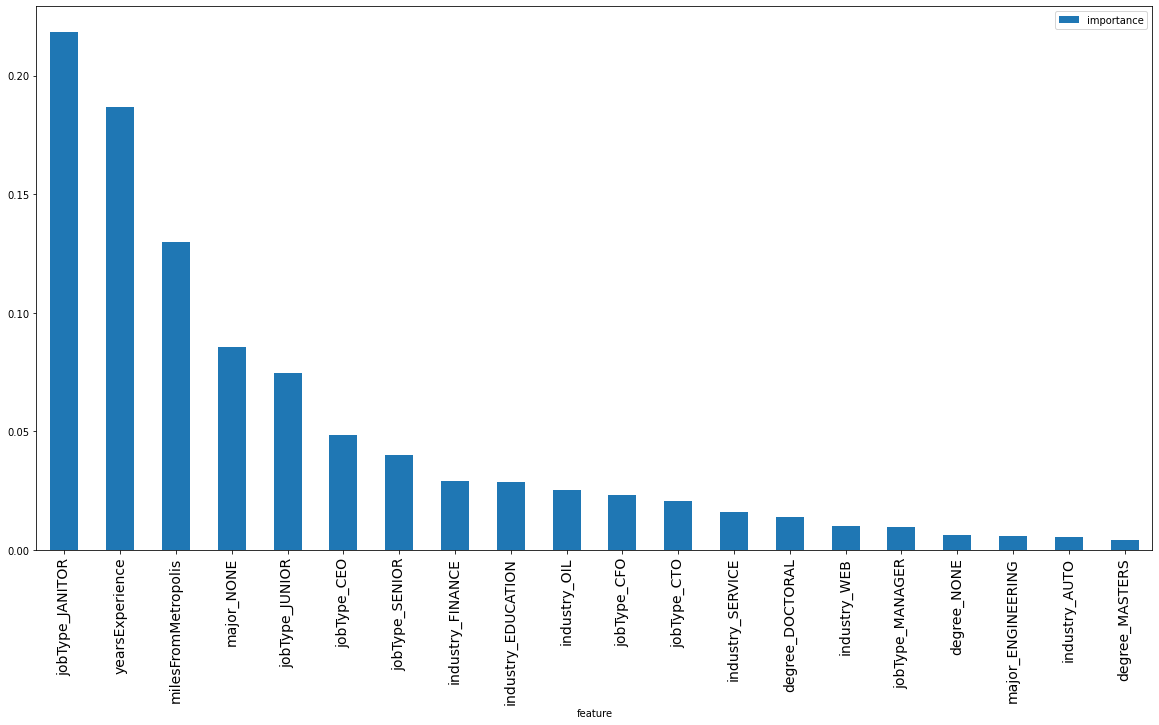

In [18]:
# Plot feature importance
feature_importances[:20].plot.bar(figsize=(20, 10))
plt.xticks(fontsize = 14)
plt.show()

In [19]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders


salary_pred_file = 'predictions.csv'
salary_pred_df = pd.read_csv(salary_pred_file, header=None)

# Combine test data with the predicted salaries
test_df['Predicted Salary']= salary_pred_df.iloc[:,0]

# Save data
test_df.to_csv('Test_Features_with_Predicted_Salary.csv')